# Data preparation

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import geopandas as gpd
import contextily as ctx
#import shapely
import shapely.wkt
from shapely.geometry import Polygon
import folium
import libpysal
from libpysal.cg import Grid, Rectangle
import esda
import rasterio 
from rasterio.transform import Affine

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

In [2]:
## Helper functions

def random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r()) 

def round_down(num, divisor):
    return np.floor(num / divisor) * divisor

def round_up(num, divisor):
    return np.ceil(num / divisor) * divisor  

In [3]:
## Krefeld, Chemnitz, Hamm

## Krefeld
xmin = 6.388
xmax = 6.669
ymin = 51.297
ymax = 51.392
bbox = BboxSelector([xmin, ymin, xmax, ymax])

## Request from api
#track_df = track_api.get_tracks(bbox=bbox, num_results=500) # requesting 500 tracks inside the bbox
#track_df.to_csv("data/krefeld/krefeld.csv")

## Read from file
columns = ['track.id','time','geometry','CO2.value']
# Pandas dataframe
track_df_pd = pd.read_csv("data/krefeld/krefeld.csv", usecols=columns)
# Convert to Geopandas dataframe
geometry = track_df_pd['geometry'].map(shapely.wkt.loads)
track_df_pd = track_df_pd.drop('geometry', axis=1)
track_df = gpd.GeoDataFrame(track_df_pd, crs="EPSG:4326", geometry=geometry)

track_df.head()

,time,track.id,CO2.value,geometry
0,2020-07-14T12:42:50,5f0dbdded2ad4700019fcddd,NaN,POINT (6.59242 51.34573)
1,2020-07-14T12:43:00,5f0dbdded2ad4700019fcddd,NaN,POINT (6.59300 51.34525)
2,2020-07-14T12:43:09,5f0dbdded2ad4700019fcddd,NaN,POINT (6.59310 51.34488)
3,2020-07-14T12:43:40,5f0dbdded2ad4700019fcddd,NaN,POINT (6.59319 51.34489)
4,2020-07-14T12:43:45,5f0dbdded2ad4700019fcddd,NaN,POINT (6.59319 51.34489)


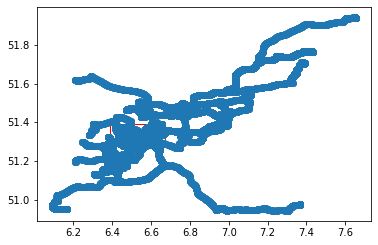

In [4]:
## Plot all tracks
bboxpoly = Polygon([(xmin, ymin,), 
                    (xmax, ymin), 
                    (xmax, ymax), 
                    (xmin, ymax)])
bboxpoly_gdf = gpd.GeoDataFrame([1],geometry=[bboxpoly])

base = bboxpoly_gdf.plot(color='white', edgecolor='red')
track_df.plot(ax=base)

10710


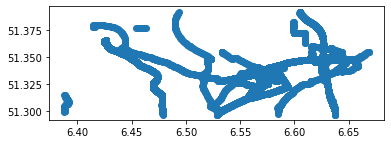

In [5]:
## Clip and (attribute) filter tracks

# Filter measurement swith CO2
track_df_sub = track_df.dropna(subset=['CO2.value'])
# Filter time
# ...
# Clip
track_df_sub = gpd.clip(track_df_sub, bboxpoly_gdf)

# Plot clipped and filtered tracks
track_df_sub.plot()

print(len(track_df_sub))

#track_df_sub.to_csv("data/krefeld/krefeld_clipped_filtered.csv")

In [6]:
## Store individual tracks separately
track_ids = track_df_sub['track.id'].unique()
tracks = []

for id in track_ids:
    tracks.append(track_df_sub[track_df_sub['track.id'] == id])

print(len(track_ids))

101


In [7]:
## Plot tracks
lat = 51.34
lng = 6.5

m = folium.Map(location=[lat, lng], zoom_start=12)

for track in tracks:
    lats = list(track['geometry'].apply(lambda coord: coord.y))
    lngs = list(track['geometry'].apply(lambda coord: coord.x))
    folium.PolyLine([coords for coords in zip(lats, lngs)], color=random_color()).add_to(m)
    
m

In [8]:
track_df_sub.head()

,time,track.id,CO2.value,geometry
5535,2020-07-10T08:25:54,5f08295430d93d341d33d4b2,2.091722,POINT (6.64193 51.35436)
5536,2020-07-10T08:25:59,5f08295430d93d341d33d4b2,12.742739,POINT (6.64147 51.35397)
5537,2020-07-10T08:26:04,5f08295430d93d341d33d4b2,9.017916,POINT (6.64093 51.35350)
5538,2020-07-10T08:26:09,5f08295430d93d341d33d4b2,4.122995,POINT (6.64037 51.35302)
5539,2020-07-10T08:26:14,5f08295430d93d341d33d4b2,9.723066,POINT (6.63986 51.35258)


# Grid

In [9]:
##  Create grid

#gridSize = 0.001
gridSize = 0.00025
xmin,ymin,xmax,ymax = track_df_sub.total_bounds
height, width = gridSize, gridSize

grid_cols = list(np.arange(round_down(xmin,gridSize), round_up(xmax,gridSize), gridSize))
grid_rows = list(np.arange(round_down(ymin,gridSize), round_up(ymax,gridSize), gridSize))
grid_rows.reverse()

polygons = []
for x in grid_cols:
    for y in grid_rows:
        polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-height), (x, y-height)]) )

grid_gdf = gpd.GeoDataFrame({'geometry':polygons})
grid_gdf.crs = track_df_sub.crs

grid_gdf.head()

#f, ax = plt.subplots(figsize=(15,15))
#track_df_sub.plot(ax=ax, marker='o', color='red', markersize=20)
#grid_gdf.plot(ax=ax, color='blue',alpha=0.7)
#plt.show()

#grid_gdf.to_csv("data/krefeld/grid.csv")
#grid_gdf.to_file("data/krefeld/grid/grid.shp")

,geometry
0,"POLYGON ((6.38800 51.39175, 6.38825 51.39175, ..."
1,"POLYGON ((6.38800 51.39150, 6.38825 51.39150, ..."
2,"POLYGON ((6.38800 51.39125, 6.38825 51.39125, ..."
3,"POLYGON ((6.38800 51.39100, 6.38825 51.39100, ..."
4,"POLYGON ((6.38800 51.39075, 6.38825 51.39075, ..."


In [11]:
## Spatial join of grid and track

field = 'CO2.value'
summary = 'mean'

# Assign grid id
grid_gdf['gridId']=list(range(len(grid_gdf)))
    
# Identify grid id for each point
grid_joined = gpd.sjoin(track_df_sub, grid_gdf, op='within')
    
# Group points by grid id and calculate mean
grouped = grid_joined.groupby('gridId')[field]
#pd.DataFrame(grouped).to_csv("data/krefeld/grouped.csv")
grouped = grouped.agg(summary)
grouped_df = pd.DataFrame(grouped)

# Add mean CO2 values to grid
co2_grid = grid_gdf.join(grouped_df, on='gridId').fillna(0)
co2_grid['x_centroid'],co2_grid['y_centroid'] = co2_grid.geometry.centroid.x,co2_grid.geometry.centroid.y

#grid_gdf.to_csv("data/krefeld/grid_gdf.csv")
#grid_joined.to_csv("data/krefeld/grid_joined.csv")
#grouped_df.to_csv("data/krefeld/grouped_df.csv")
#co2_grid.to_csv("data/krefeld/co2_grid.csv")

427120
3825


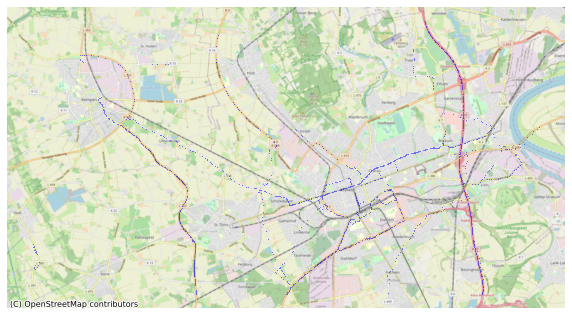

In [12]:
## Plot grid cells which contain CO2 values

print(len(co2_grid))
print(len(co2_grid[co2_grid[field]>0].to_crs(epsg=3857)))

ax = co2_grid[co2_grid[field]>0].to_crs(epsg=3857).plot(figsize=(10,10), alpha=0.5,color='b')
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
# Basemaps:
# https://github.com/geopandas/contextily/blob/master/contextily/_providers.py
# source=ctx.providers.Stamen.TonerLite
# source=ctx.providers.OpenStreetMap.DE 

# Hotspot analysis

In [13]:
# Calculate weights

#threshold = 0.02
threshold = 0.003 # 0.003 / 0.00025 = 12 (cells)

co2_hotspot = co2_grid[co2_grid['CO2.value']>0]

coords = [(x,y) for x,y in zip(co2_hotspot['x_centroid'], co2_hotspot['y_centroid'])]
#print(len(coords))
#print(coords)

# Calculate weights
w = libpysal.weights.DistanceBand(coords, threshold)
#print(len(w.weights))
#print(w.weights)


/home/martin/.local/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


In [14]:
# Calculate local Getis Ord statistic

getisOrdLocal = esda.getisord.G_Local(co2_hotspot['CO2.value'], w, transform='B')

#co2_hotspot = co2_grid
co2_hotspot = co2_hotspot.assign(z_score = getisOrdLocal.Zs)
co2_hotspot = co2_hotspot.assign(p_value = getisOrdLocal.p_norm)
#co2_hotspot['z_score'] = getisOrdLocal.Zs
#co2_hotspot['p_value'] = getisOrdLocal.p_norm

#co2_hotspot.to_csv("data/krefeld/co2_hotspot.csv")

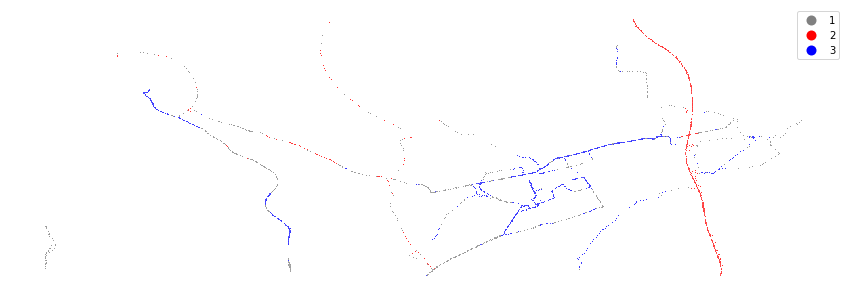

In [15]:
## Plot hotspots/coldspots

# https://pro.arcgis.com/de/pro-app/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm
# 0.1 / 1.65, 0.05 / 1.96, 0.01 / 2.58
significance_lvl = 0.1
critical_lvl = 1.65

hcmap = colors.ListedColormap(['grey','red','blue'])

significant = co2_hotspot['p_value'] < significance_lvl
hotspots = (co2_hotspot['z_score']>critical_lvl) & significant
coldspots = (co2_hotspot['z_score']<(-critical_lvl)) & significant

co2_hotspot = co2_hotspot.assign(significant = significant)
co2_hotspot = co2_hotspot.assign(hotspots = hotspots)
co2_hotspot = co2_hotspot.assign(coldspots = coldspots)

# 1=hotcold spot, 2=hotspot, 3=coldspot
hotspot_index = 1 + hotspots*1 + coldspots*2
co2_hotspot = co2_hotspot.assign(hotspot_index = hotspot_index)
hcmap = colors.ListedColormap(['grey', 'red','blue'])
f, ax = plt.subplots(1, figsize=(15, 15))
co2_hotspot.plot(column='hotspot_index', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

#co2_hotspot.to_csv("data/krefeld/co2_hotspot.csv")

In [16]:
# Size of grid
print(len(grid_cols))
print(len(grid_rows))

605
269


# Save as geotiff

In [16]:
## Save CO2 values in geotiff

co2_values = co2_grid["CO2.value"]
co2_values = np.array(co2_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction


# Daten um 180° rotiert!
#res = gridSize
#transform = Affine.translation(grid_cols[0] - res / 2, grid_rows[-1] - res / 2) * Affine.scale(res, res)

transform = rasterio.transform.from_origin(grid_cols[0], grid_rows[0], gridSize, gridSize)

meta = {'driver' :'GTiff', 
        'width' : len(grid_cols), 
        'height' : len(grid_rows),
        'count' : 1, 
        'dtype' : co2_grid["CO2.value"].dtype, 
        'crs' : '+proj=latlong',
        'transform' : transform,
       }

new_dataset = rasterio.open(
    'data/krefeld/images/co2_grid.tif',
    'w',
    **meta,
)

new_dataset.write(co2_values, 1)
new_dataset.close()

In [41]:
co2_hotspot["z_score"].dtype

dtype('float64')

In [17]:
def save_raster(data, outname, dtype, grid_cols, grid_rows, gridSize):
    
    transform = rasterio.transform.from_origin(grid_cols[0], grid_rows[0], gridSize, gridSize)

    meta = {'driver' :'GTiff', 
            'width' : len(grid_cols), 
            'height' : len(grid_rows),
            'count' : 1, 
            'dtype' : dtype, 
            'crs' : '+proj=latlong',
            'transform' : transform,
           }
    
    new_dataset = rasterio.open(
        outname,
        'w',
        **meta,
    )
    new_dataset.write(data, 1)
    new_dataset.close()

In [18]:
## Save z and p values in geotiff
# nan are automatically added in the geotiff if no data is available for a specific grid cell

drop = ['geometry','x_centroid','y_centroid','significant','hotspots','coldspots','CO2.value']
temp = co2_hotspot.drop(drop, axis=1)
results = grid_gdf.join(temp.set_index('gridId'), on='gridId')
results.to_csv("data/krefeld/results.csv")

z_values = results["z_score"]
z_values = np.array(z_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
p_values = results["p_value"]
p_values = np.array(p_values).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index = results["hotspot_index"]
hotspot_index = np.array(hotspot_index).reshape(len(grid_rows), len(grid_cols), order='F') # order: set fast/slow direction
hotspot_index = hotspot_index.astype('int8') 

save_raster(z_values, 'data/krefeld/images/z_values.tif', 'float64', grid_cols, grid_rows, gridSize)
save_raster(p_values, 'data/krefeld/images/p_values.tif', 'float64', grid_cols, grid_rows, gridSize)
save_raster(hotspot_index, 'data/krefeld/images/hotspot_index.tif', np.dtype(np.int8) ,grid_cols, grid_rows, gridSize)